<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Kevin_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tqdm import tqdm
import warnings
import random
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.multitest import multipletests

warnings.filterwarnings("ignore")

In [16]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

# For quantile normalization
!pip install qnorm
import qnorm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

In [18]:
expression.head()

,1000_at,1001_at,1002_f_at,1003_s_at,1004_at,1005_at,1006_at,1007_s_at,1008_f_at,1009_at,...,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-YEL002c/WBP1_at,AFFX-YEL018w/_at,AFFX-YEL021w/URA3_at,AFFX-YEL024w/RIP1_at,AFFX-hum_alu_at
01_a_D_f_2.CEL,9.521934,7.453767,7.045636,7.743690,7.728274,8.081243,6.927978,9.294152,8.888816,8.290944,...,7.065597,6.803698,6.631766,6.981474,7.003319,6.999630,7.005495,6.864895,7.030665,14.394582
01_a_I_f_2.CEL,10.930684,9.455482,9.233291,9.777128,9.612399,9.845444,9.149639,10.580062,11.505571,9.846817,...,9.366604,9.067484,8.945584,9.118070,9.137492,9.067202,9.129742,9.256544,9.171725,15.494106
01_a_M_f_1.CEL,6.852731,5.298974,5.033266,6.040661,5.890083,5.810144,5.098923,6.240855,7.280948,6.124910,...,5.374457,5.165619,5.032617,5.382904,5.509690,5.113946,5.273243,5.321357,5.321636,12.856782
01_c_D_f_1.CEL,7.285181,6.258114,6.119443,6.631768,6.744592,6.589478,6.156638,7.417750,8.663882,8.203275,...,6.332162,6.278864,6.108778,6.341791,6.339638,6.167335,6.170734,6.734936,6.275118,13.683484
01_c_I_f_2.CEL,11.224543,9.800931,9.407753,10.113212,9.871853,10.495533,9.449701,11.084619,11.969619,10.479006,...,9.443910,9.242560,9.272848,9.435175,9.448927,9.395768,9.306998,9.863770,9.404475,15.494106


In [19]:
genes.head()

,sym,chrom
rownames,,
1000_at,MAPK3,16
1001_at,TIE1,1
1002_f_at,CYP2C19,10
1003_s_at,CXCR5,11
1004_at,CXCR5,11


In [20]:
samples.head()

,patient,sex,region,lab,chip.version
rownames,,,,,
01_a_D_f_2.CEL,patient_01,female,A.C. cortex,Davis,v2
01_a_I_f_2.CEL,patient_01,female,A.C. cortex,Irvine,v2
01_a_M_f_1.CEL,patient_01,female,A.C. cortex,Michigan,v1
01_c_D_f_1.CEL,patient_01,female,cerebellum,Davis,v1
01_c_I_f_2.CEL,patient_01,female,cerebellum,Irvine,v2


In [21]:
genes.at["AFFX-BioDn-3_at", 'chrom'] = float("Nan")
genes_control = genes[['AFFX' in s for s in genes.index]]
genes_control = genes_control[['HUM' not in s for s in genes_control.index]]
genes_control = genes_control[['hum' not in s for s in genes_control.index]]
genes_bac_index = genes_control[genes_control.chrom.isnull() & genes_control.sym.isnull()].index
genes_hum_index = [x for x in genes.index if x not in genes_bac_index]

In [22]:
len(genes_bac_index)

44

In [23]:
len([x for x in genes.index if 'AFFX' in x and x not in genes_bac_index])

23

In [24]:
genes_sym = genes[genes.sym.notnull()]
unique_genes = genes_sym["sym"].unique()
gene_to_probe_set = {}

for gene in unique_genes:
  gene_to_probe_set[gene] = genes_sym.index[genes_sym.sym == gene].tolist()

## Gene Expression in the Brain

### 1. Data Overview and Processing

In the study, there are 10 patients, 5 males and 5 females, indicated by patient_01 to patient_10. For each patient, log expressions for 12,600 probe sets (some represent human control or bacteria control probe sets) are collected in 3 regions of the brain, namely A.C. cortex, cerebellum and D.L.P.F. cortex. This process is replicated across 3 labs: UC Davis, UC Irvine and University of Michigan. Davis and Michigan labs measure gene expressions using both chip versions (v1 and v2), while Irvine lab only uses chip version v2. Ideally, we have 10 x 3 = 30 patient-region pairs for each lab. While this is true for Irvine and Michigan, we only have 24 pairs for Davis.

We categorize the probe sets following the convention below.

- Bacteria control probe sets are exactly those satisfying all the following criteria: (1) contains AFFX; (2) does not contain HUM (or hum); (3) has the value NA for both chromosome and symbol
- Human control probe sets are exactly those satisfying all the following criteria: (1) contains AFFX; (2) is not a bacteria control probe set. This is used as a sanity check (i.e., our model should not output genes corresponding to these probe sets [ACTB, GAPDH, STAT1, TFRC] as differentially expressed)
- "True gene" probe sets: all probe sets which are not (bacteria or human) control probe sets

There are 44 bacteria control probe sets, 23 human control probe sets and 12,533 true gene probe sets. In addition, it is important to note that one probe set can correspond to multiple genes. Since our ultimate goal is to recommend differentially expressed genes and the analysis is done for each probe set, we follow a conservative approach of selecting the worst-performing probe set for each gene.

Finally, some true gene probe sets have NAs as their symbols. For simplicity, we remove these genes from our analyses.

### 2. Non-Biological Variability in Gene Expression

This section investigates the presence of non-biological variability in gene expression, which needs to be eliminated in order to obtain more convincing results. A simple box plot of log expressions for each microarray (corresponding to one person-region-lab triplet) indicates a strong indication of microarray and lab effects. With regard to lab effect, we tend to see lower values for Michigan and higher values for Irvine.

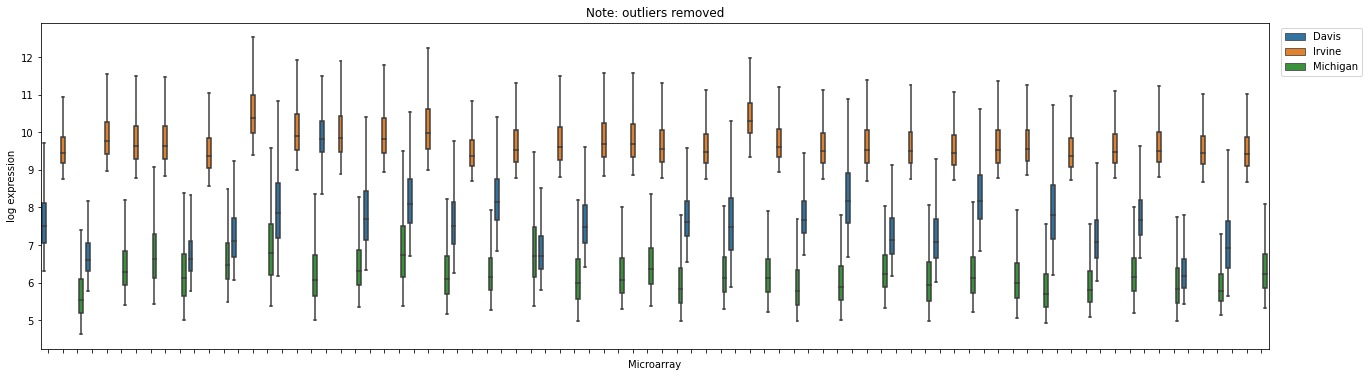

In [25]:
t = pd.melt(expression.T)
t = pd.merge(t, samples[['lab']], left_on='variable', right_index = True)

fig, ax = plt.subplots(1, 1, figsize=(22, 6), sharey = "all")
sns.boxplot(x="variable", y="value", data=t, hue = 'lab', showfliers = False)
ax.set_xlabel("Microarray")
ax.set_ylabel("log expression")
ax.set(xticklabels=[])
ax.title.set_text('Note: outliers removed')
ax.legend(bbox_to_anchor=(1.08, 1))

Now, we can zoom into Davis and Michigan, the labs with both chip versions, to see if there is any apparent chip version effect. As seen on the plots below, there seems to be some chip version effect.

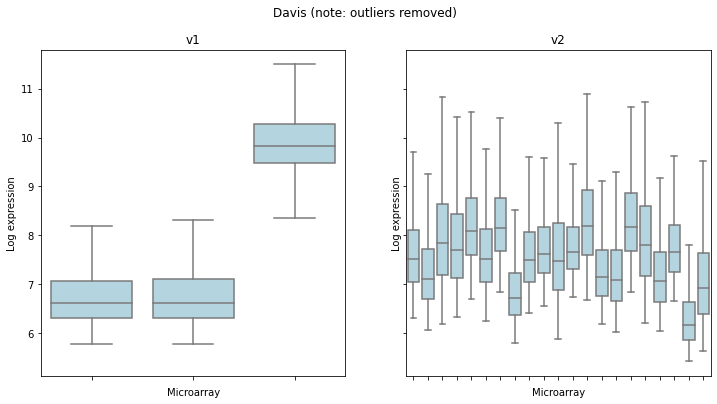

In [26]:
t = pd.melt(expression.T)
t = pd.merge(t, samples[['lab', 'chip.version']], left_on='variable', right_index = True)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey = "all")
c = 0

for chip_version in ['v1', 'v2']:
  temp = t[(t['lab'] == 'Davis') & (t['chip.version'] == chip_version)]
  sns.boxplot(x="variable", y="value", data=temp, showfliers = False, ax = axs[c], color = 'lightblue')
  axs[c].set_xlabel("Microarray")
  axs[c].set_ylabel("Log expression")
  axs[c].set(xticklabels=[])
  axs[c].title.set_text(chip_version)
  c += 1
plt.suptitle('Davis (note: outliers removed)');

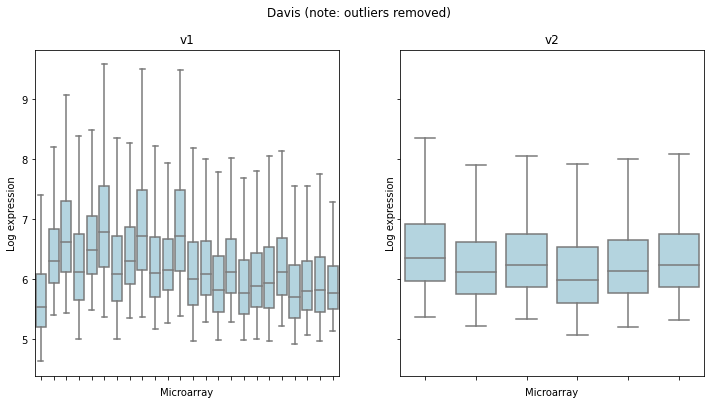

In [27]:
t = pd.melt(expression.T)
t = pd.merge(t, samples[['lab', 'chip.version']], left_on='variable', right_index = True)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey = "all")
c = 0

for chip_version in ['v1', 'v2']:
  temp = t[(t['lab'] == 'Michigan') & (t['chip.version'] == chip_version)]
  sns.boxplot(x="variable", y="value", data=temp, showfliers = False, ax = axs[c], color = 'lightblue')
  axs[c].set_xlabel("Microarray")
  axs[c].set_ylabel("Log expression")
  axs[c].set(xticklabels=[])
  axs[c].title.set_text(chip_version)
  c += 1
plt.suptitle('Davis (note: outliers removed)');

It is also interesting to see how the log expression for each patient-region pair varies across lab locations. As there are more than 12,000 probe sets, we select 3 of them at random. The line plots below show that the scales of log expressions for probe set 38654_at, 34714_at and 37208_at differ across lab locations for each patient-region index.

In [39]:
davis = expression[expression.index.str.contains('_D_')]
irvine = expression[expression.index.str.contains('_I_')]
michigan = expression[expression.index.str.contains('_M_')]
davis.index = [x.replace('_D','').replace('_1','').replace('_2','') for x in davis.index]
irvine.index = [x.replace('_I','').replace('_1','').replace('_2','') for x in irvine.index]
michigan.index = [x.replace('_M','').replace('_1','').replace('_2','') for x in michigan.index]

def linepl(var_name):
  temp = pd.merge(irvine[[var_name]], davis[[var_name]], how = 'left', left_index = True, right_index = True) \
    .merge(michigan[[var_name]], how = 'left', left_index = True, right_index = True)
  plt.plot(np.arange(1,31), temp[var_name + '_y'], marker = 'o', markersize = 4, label = 'Davis')
  plt.plot(np.arange(1,31), temp[var_name + '_x'], marker = 'o', markersize = 4, label = 'Irvine')
  plt.plot(np.arange(1,31), temp[var_name], marker = 'o', markersize = 4, label = 'Michigan')
  plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right")
  plt.xlabel('Patient-region index');
  plt.ylabel('Log expression');
  plt.title('Log expression for each patient-region in each lab (' + var_name + ')')

random.seed(2022)
random.sample(range(len(genes_hum_index)), 3)

[8710, 4733, 7251]

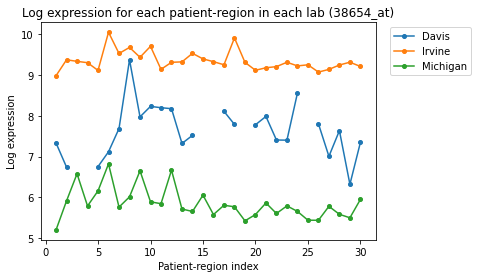

In [36]:
linepl(genes_hum_index[8710])

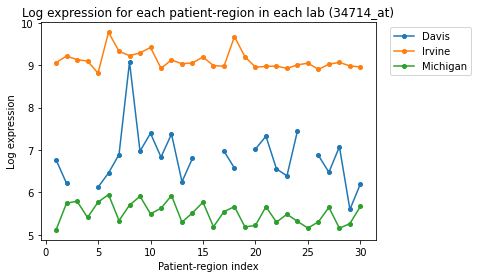

In [37]:
linepl(genes_hum_index[4733])

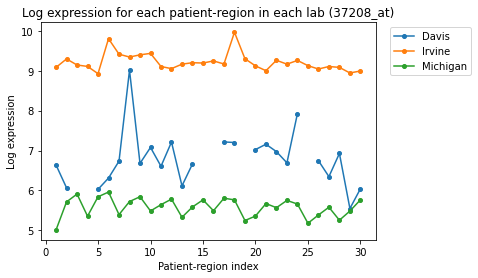

In [38]:
linepl(genes_hum_index[7251])

### 3. Bacteria Normalization

(+ Vinod's write-up)

We can recreate the above plots using the normalized log expression, and visually conclude that some (but not all) of the unwanted variations have been removed. While we have removed the variations for Irvine and Michigan reasonably well, the same does not apply to Davis, as shown clearly in the line plots.

In [61]:
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)
express_norm_samp = pd.concat([expression_norm, samples], axis=1)

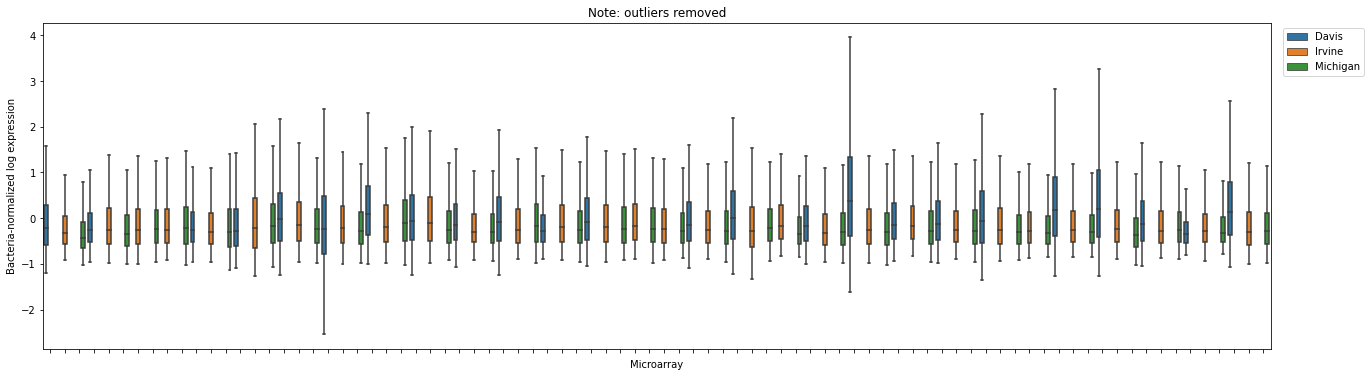

In [41]:
t = pd.melt(expression_norm.T)
t = pd.merge(t, samples['lab'], left_on='variable', right_index = True)

fig, ax = plt.subplots(1, 1, figsize=(22, 6), sharey = "all")
sns.boxplot(x="variable", y="value", data=t, hue = 'lab', showfliers = False)
ax.set_xlabel("Microarray")
ax.set_ylabel("Bacteria-normalized log expression")
ax.set(xticklabels=[])
ax.title.set_text('Note: outliers removed')
ax.legend(bbox_to_anchor=(1.08, 1))

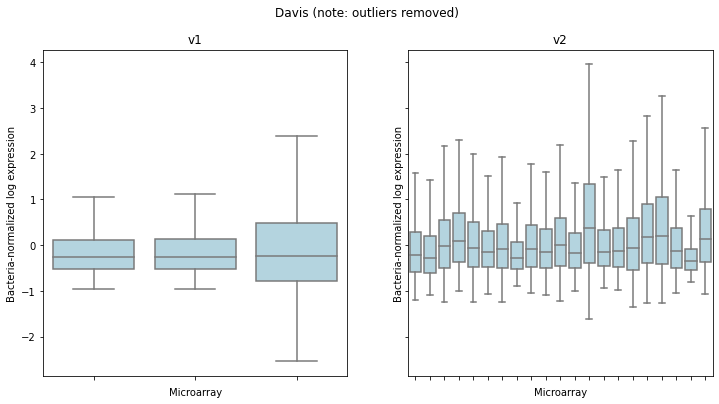

In [42]:
t = pd.melt(expression_norm.T)
t = pd.merge(t, samples[['lab', 'chip.version']], left_on='variable', right_index = True)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey = "all")
c = 0

for chip_version in ['v1', 'v2']:
  temp = t[(t['lab'] == 'Davis') & (t['chip.version'] == chip_version)]
  sns.boxplot(x="variable", y="value", data=temp, showfliers = False, ax = axs[c], color = 'lightblue')
  axs[c].set_xlabel("Microarray")
  axs[c].set_ylabel("Bacteria-normalized log expression")
  axs[c].set(xticklabels=[])
  axs[c].title.set_text(chip_version)
  c += 1
plt.suptitle('Davis (note: outliers removed)');

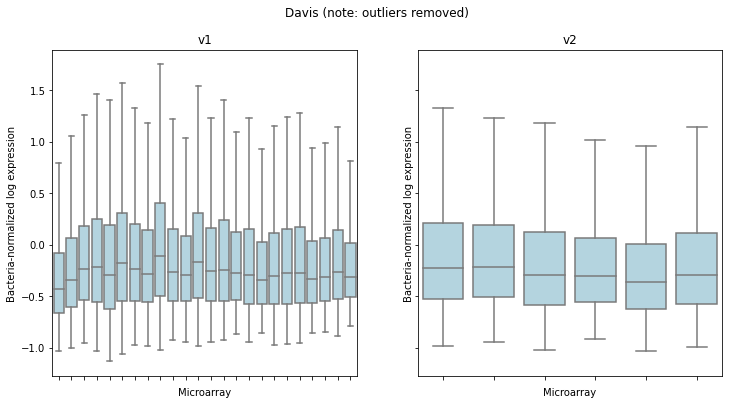

In [43]:
t = pd.melt(expression_norm.T)
t = pd.merge(t, samples[['lab', 'chip.version']], left_on='variable', right_index = True)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey = "all")
c = 0

for chip_version in ['v1', 'v2']:
  temp = t[(t['lab'] == 'Michigan') & (t['chip.version'] == chip_version)]
  sns.boxplot(x="variable", y="value", data=temp, showfliers = False, ax = axs[c], color = 'lightblue')
  axs[c].set_xlabel("Microarray")
  axs[c].set_ylabel("Bacteria-normalized log expression")
  axs[c].set(xticklabels=[])
  axs[c].title.set_text(chip_version)
  c += 1
plt.suptitle('Davis (note: outliers removed)');

In [51]:
davis = expression_norm[expression_norm.index.str.contains('_D_')]
irvine = expression_norm[expression_norm.index.str.contains('_I_')]
michigan = expression_norm[expression_norm.index.str.contains('_M_')]
davis.index = [x.replace('_D','').replace('_1','').replace('_2','') for x in davis.index]
irvine.index = [x.replace('_I','').replace('_1','').replace('_2','') for x in irvine.index]
michigan.index = [x.replace('_M','').replace('_1','').replace('_2','') for x in michigan.index]

def linepl(var_name):
  temp = pd.merge(irvine[[var_name]], davis[[var_name]], how = 'left', left_index = True, right_index = True) \
    .merge(michigan[[var_name]], how = 'left', left_index = True, right_index = True)
  plt.plot(np.arange(1,31), temp[var_name + '_y'], marker = 'o', markersize = 4, label = 'Davis')
  plt.plot(np.arange(1,31), temp[var_name + '_x'], marker = 'o', markersize = 4, label = 'Irvine')
  plt.plot(np.arange(1,31), temp[var_name], marker = 'o', markersize = 4, label = 'Michigan')
  plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right")
  plt.xlabel('Patient-region index');
  plt.ylabel('Bacteria-normalized log expression');
  plt.title('Log expression for each patient-region in each lab (' + var_name + ')')

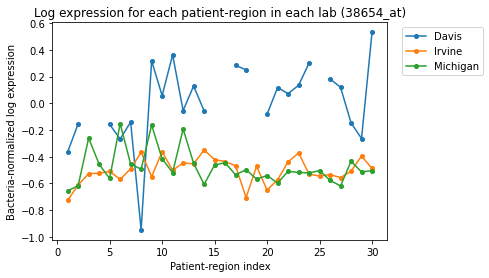

In [52]:
linepl(genes_hum_index[8710])

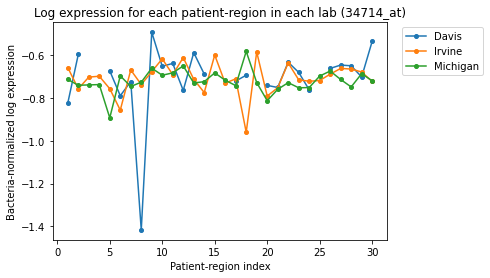

In [53]:
linepl(genes_hum_index[4733])

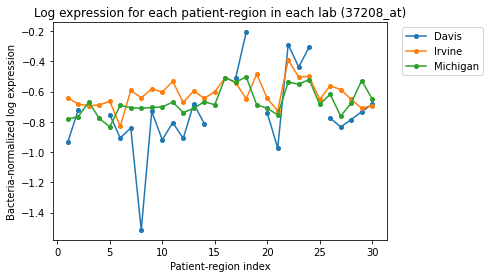

In [54]:
linepl(genes_hum_index[7251])

Finally, we can compare our bacteria normalization method with quantile normalization, which is arguably the most widely used normalization method for microarray data. It is worth noting that this method does not require any control values. We re-generate the above line plots after changing the normalization method to quantile normalization. 

It can be seen that our method seems to do better in removing unwanted variation as compared to quantile normalization (especially for probe set 34714_at). 

In [55]:
expression_qnorm = qnorm.quantile_normalize(expression, axis=0)
davis = expression_qnorm[expression_qnorm.index.str.contains('_D_')]
irvine = expression_qnorm[expression_qnorm.index.str.contains('_I_')]
michigan = expression_qnorm[expression_qnorm.index.str.contains('_M_')]
davis.index = [x.replace('_D','').replace('_1','').replace('_2','') for x in davis.index]
irvine.index = [x.replace('_I','').replace('_1','').replace('_2','') for x in irvine.index]
michigan.index = [x.replace('_M','').replace('_1','').replace('_2','') for x in michigan.index]

def linepl(var_name):
  temp = pd.merge(irvine[[var_name]], davis[[var_name]], how = 'left', left_index = True, right_index = True) \
    .merge(michigan[[var_name]], how = 'left', left_index = True, right_index = True)
  plt.plot(np.arange(1,31), temp[var_name + '_y'], marker = 'o', markersize = 4, label = 'Davis')
  plt.plot(np.arange(1,31), temp[var_name + '_x'], marker = 'o', markersize = 4, label = 'Irvine')
  plt.plot(np.arange(1,31), temp[var_name], marker = 'o', markersize = 4, label = 'Michigan')
  plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right")
  plt.xlabel('Patient-region index');
  plt.ylabel('Quantile-normalized log expression');
  plt.title('Log expression for each patient-region in each lab (' + var_name + ')')

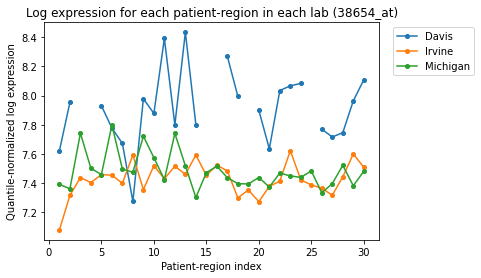

In [56]:
linepl(genes_hum_index[8710])

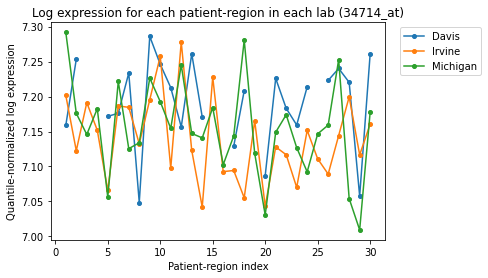

In [57]:
linepl(genes_hum_index[4733])

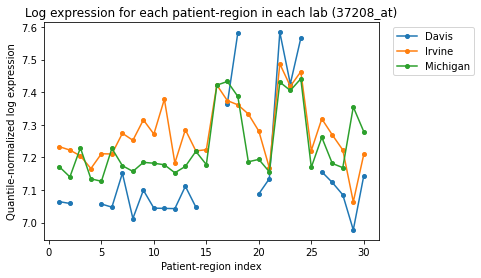

In [58]:
linepl(genes_hum_index[7251])

### 4. Regression-Based Method

We fit linear regression models on the bacteria-normalized data, assuming microarray-level variations have been eliminated. In particular, for each probe set, we consider the following models:

- For all labs combined: 
$$\textrm{log expression} = a + b \cdot \textrm{I(male)} + c \cdot \textrm{I(AC cortex)} + d \cdot \textrm{I(cerebellum)} + e \cdot \textrm{I(Davis)} + f \cdot \textrm{I(Irvine)} + \textrm{error}$$
- For each of the 3 labs: 
$$\textrm{log expression} = a + b \cdot \textrm{I(male)} + c \cdot \textrm{I(AC cortex)} + d \cdot \textrm{I(cerebellum)} + \textrm{error}$$

We are particularly interested in the p-value corresponding to the null hypothesis $H_0: b = 0$ versus the alternative hypothesis $H_A: b \neq 0$. Before fitting the regression models, we first check if the homoscedasticity assumption is satisfied. Since we need to fit around 50,000 models, manual inspection is intractable and we resort to White's Lagrange Multiplier test.


In [64]:
samples_tmp = samples.drop(columns= ["patient", "chip.version"]);
one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum", "lab_Davis"]);
X = sm.add_constant(one_hot_encoding);

hetero_test_w = []
for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(express_norm_samp[gene],X);
  results = model.fit();
  white_test = het_white(results.resid,  results.model.exog)
  hetero_test_w.append((gene, white_test[1]))

len([x for x in hetero_test_w if x[1] <= 0.01])

100%|██████████| 12556/12556 [00:43<00:00, 287.61it/s]


1193

In [95]:
temp = express_norm_samp[express_norm_samp['lab'] == 'Davis']
samples_tmp = samples[samples['lab'] == 'Davis']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);

one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

hetero_test_w = []
for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit();
  white_test = het_white(results.resid,  results.model.exog)
  hetero_test_w.append((gene, white_test[1]))

len([x for x in hetero_test_w if x[1] <= 0.01])

100%|██████████| 12556/12556 [00:29<00:00, 425.78it/s]


32

In [96]:
temp = express_norm_samp[express_norm_samp['lab'] == 'Irvine']
samples_tmp = samples[samples['lab'] == 'Irvine']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);

one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

hetero_test_w = []
for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit();
  white_test = het_white(results.resid,  results.model.exog)
  hetero_test_w.append((gene, white_test[1]))

len([x for x in hetero_test_w if x[1] <= 0.01])

100%|██████████| 12556/12556 [00:24<00:00, 509.82it/s]


344

In [97]:
temp = express_norm_samp[express_norm_samp['lab'] == 'Michigan']
samples_tmp = samples[samples['lab'] == 'Michigan']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);

one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

hetero_test_w = []
for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit();
  white_test = het_white(results.resid,  results.model.exog)
  hetero_test_w.append((gene, white_test[1]))

len([x for x in hetero_test_w if x[1] <= 0.01])

100%|██████████| 12556/12556 [00:25<00:00, 494.20it/s]


337

The results show that for the model with all the labs combined, there is an evidence of heteroscedasticity at 0.01 level for 1,193 probe sets. The corresponding numbers are 32, 344 and 337 for Davis-only, Irvine-only and Michigan-only models, respectively. Based on this result, we use heteroscedasticity-consistent standard errors for all our regression models. For all labs combined, we found the following 10 genes have the smallest p-value corresponding to the null hypothesis $H_0: b = 0$.

In [101]:
samples_tmp = samples.drop(columns= ["patient", "chip.version"]);
one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum", "lab_Davis"]);
X = sm.add_constant(one_hot_encoding);

coef_gene = []
for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(express_norm_samp[gene],X);
  results = model.fit(cov_type='HC3');
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

res = []
for gene in gene_to_probe_set:
  probes = gene_to_probe_set[gene]
  temp = [x for x in coef_gene if x[0] in probes]
  max_pval = -100
  max_pval_gene = None
  for i in temp:
    if i[1] > max_pval:
      max_pval = i[1]
      max_pval_gene = i[0]
  res.append((max_pval_gene, max_pval))

sorted_coef_gene = sorted(res, key=lambda tup: tup[1])
top10genes = [tup[0] for tup in sorted_coef_gene[:10]]

print('Top 10 genes chromosome:', np.array(genes.loc[top10genes].loc[:, 'chrom'].values))
print('Top 10 genes symbol:', np.array(genes.loc[top10genes].loc[:, 'sym'].values))
print('Top 10 genes p-values:', np.array([x[1] for x in sorted_coef_gene[:10]]))

100%|██████████| 12556/12556 [00:20<00:00, 604.80it/s]


Top 10 genes chromosome: ['Y' 'Y' 'Y' 'Y' 'X' 'Y' 'Y' 'Y' 'Y' '6']
Top 10 genes symbol: ['RPS4Y1' 'DDX3Y' 'KDM5D' 'USP9Y' 'XIST' 'UTY' 'TTTY15' 'CYorf15B'
 'NLGN4Y' 'CD24']
Top 10 genes p-values: [8.18137189e-56 1.03243941e-21 7.20130065e-17 5.70864697e-14
 6.93846744e-13 1.60712772e-12 1.55812750e-07 3.02885530e-05
 1.42822938e-04 8.66504267e-04]


Controlling for false discovery rate with $p = 0.05$ using the Benjamini-Hochberg procedure, we obtain 8 significant genes as shown below.

In [102]:
index_sign = np.where(multipletests([x[1] for x in res], method="fdr_bh")[0])[0]
probe_sets = np.array([x[0] for x in res])[index_sign]
print('Top genes chromosome from BH with p = 0.05:', np.array(genes.loc[probe_sets].loc[:, 'chrom'].values))
print('Top genes symbol from BH with p = 0.05:', np.array(genes.loc[probe_sets].loc[:, 'sym'].values))

Top genes chromosome from BH with p = 0.05: ['Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'X' 'Y']
Top genes symbol from BH with p = 0.05: ['UTY' 'USP9Y' 'TTTY15' 'KDM5D' 'CYorf15B' 'DDX3Y' 'XIST' 'RPS4Y1']


We can repeat the same analysis for individual labs. For the Davis lab, we have

In [99]:
temp = express_norm_samp[express_norm_samp['lab'] == 'Davis']
samples_tmp = samples[samples['lab'] == 'Davis']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);

one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

coef_gene = []
for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit(cov_type='HC3');
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

res = []
for gene in gene_to_probe_set:
  probes = gene_to_probe_set[gene]
  temp = [x for x in coef_gene if x[0] in probes]
  max_pval = -100
  max_pval_gene = None
  for i in temp:
    if i[1] > max_pval:
      max_pval = i[1]
      max_pval_gene = i[0]
  res.append((max_pval_gene, max_pval))

sorted_coef_gene = sorted(res, key=lambda tup: tup[1])
top10genes = [tup[0] for tup in sorted_coef_gene[:10]]

print('Top 10 genes chromosome:', np.array(genes.loc[top10genes].loc[:, 'chrom'].values))
print('Top 10 genes symbol:', np.array(genes.loc[top10genes].loc[:, 'sym'].values))
print('Top 10 genes p-values:', np.array([x[1] for x in sorted_coef_gene[:10]]))

100%|██████████| 12556/12556 [00:23<00:00, 538.76it/s]


Top 10 genes chromosome: ['Y' 'Y' 'Y' 'Y' 'Y' 'X' 'Y' 'Y' '6' 'Y']
Top 10 genes symbol: ['RPS4Y1' 'DDX3Y' 'USP9Y' 'UTY' 'TTTY15' 'XIST' 'KDM5D' 'NLGN4Y' 'CD24'
 'EIF1AY']
Top 10 genes p-values: [8.53777911e-31 1.67182494e-29 2.61252836e-08 1.24282753e-07
 1.24898886e-05 2.08797896e-05 9.97008211e-05 4.68195129e-04
 4.42057195e-03 1.04802591e-02]


In [100]:
index_sign = np.where(multipletests([x[1] for x in res], method="fdr_bh")[0])[0]
probe_sets = np.array([x[0] for x in res])[index_sign]
print('Top genes chromosome from BH with p = 0.05:', np.array(genes.loc[probe_sets].loc[:, 'chrom'].values))
print('Top genes symbol from BH with p = 0.05:', np.array(genes.loc[probe_sets].loc[:, 'sym'].values))

Top genes chromosome from BH with p = 0.05: ['Y' 'Y' 'Y' 'Y' 'X' 'Y']
Top genes symbol from BH with p = 0.05: ['UTY' 'USP9Y' 'TTTY15' 'DDX3Y' 'XIST' 'RPS4Y1']


For the Irvine lab, we have

In [103]:
temp = express_norm_samp[express_norm_samp['lab'] == 'Irvine']
samples_tmp = samples[samples['lab'] == 'Irvine']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);

one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

coef_gene = []
for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit(cov_type='HC3');
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

res = []
for gene in gene_to_probe_set:
  probes = gene_to_probe_set[gene]
  temp = [x for x in coef_gene if x[0] in probes]
  max_pval = -100
  max_pval_gene = None
  for i in temp:
    if i[1] > max_pval:
      max_pval = i[1]
      max_pval_gene = i[0]
  res.append((max_pval_gene, max_pval))

sorted_coef_gene = sorted(res, key=lambda tup: tup[1])
top10genes = [tup[0] for tup in sorted_coef_gene[:10]]

print('Top 10 genes chromosome:', np.array(genes.loc[top10genes].loc[:, 'chrom'].values))
print('Top 10 genes symbol:', np.array(genes.loc[top10genes].loc[:, 'sym'].values))
print('Top 10 genes p-values:', np.array([x[1] for x in sorted_coef_gene[:10]]))

100%|██████████| 12556/12556 [00:23<00:00, 538.04it/s]


Top 10 genes chromosome: ['Y' 'Y' 'Y' 'Y' 'X' 'Y' '2' '12' '6' '7']
Top 10 genes symbol: ['RPS4Y1' 'DDX3Y' 'UTY' 'KDM5D' 'XIST' 'USP9Y' 'REG1P' 'APAF1' 'KIF25'
 'LRRC17']
Top 10 genes p-values: [9.57822625e-35 1.16709105e-22 1.94335746e-16 3.57247870e-13
 1.59301595e-12 5.26801526e-10 8.55829281e-04 7.82465794e-03
 1.20490310e-02 1.24684822e-02]


In [104]:
index_sign = np.where(multipletests([x[1] for x in res], method="fdr_bh")[0])[0]
probe_sets = np.array([x[0] for x in res])[index_sign]
print('Top genes chromosome from BH with p = 0.05:', np.array(genes.loc[probe_sets].loc[:, 'chrom'].values))
print('Top genes symbol from BH with p = 0.05:', np.array(genes.loc[probe_sets].loc[:, 'sym'].values))

Top genes chromosome from BH with p = 0.05: ['Y' 'Y' 'Y' 'Y' 'X' 'Y']
Top genes symbol from BH with p = 0.05: ['UTY' 'USP9Y' 'KDM5D' 'DDX3Y' 'XIST' 'RPS4Y1']


For the Michigan lab, we have

In [106]:
temp = express_norm_samp[express_norm_samp['lab'] == 'Michigan']
samples_tmp = samples[samples['lab'] == 'Michigan']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);

one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

coef_gene = []
for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit(cov_type='HC3');
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

res = []
for gene in gene_to_probe_set:
  probes = gene_to_probe_set[gene]
  temp = [x for x in coef_gene if x[0] in probes]
  max_pval = -100
  max_pval_gene = None
  for i in temp:
    if i[1] > max_pval:
      max_pval = i[1]
      max_pval_gene = i[0]
  res.append((max_pval_gene, max_pval))

sorted_coef_gene = sorted(res, key=lambda tup: tup[1])
top10genes = [tup[0] for tup in sorted_coef_gene[:10]]

print('Top 10 genes chromosome:', np.array(genes.loc[top10genes].loc[:, 'chrom'].values))
print('Top 10 genes symbol:', np.array(genes.loc[top10genes].loc[:, 'sym'].values))
print('Top 10 genes p-values:', np.array([x[1] for x in sorted_coef_gene[:10]]))

100%|██████████| 12556/12556 [00:19<00:00, 652.48it/s]


Top 10 genes chromosome: ['Y' 'Y' 'Y' 'X' 'Y' '8' 'Y' '19' 'Y' '16']
Top 10 genes symbol: ['RPS4Y1' 'DDX3Y' 'KDM5D' 'XIST' 'TTTY15' 'MOS' 'CYorf15B' 'LYL1' 'USP9Y'
 'MYLPF']
Top 10 genes p-values: [1.34904816e-25 1.81951685e-23 5.23891632e-06 1.10398906e-05
 1.46451533e-05 1.70551547e-05 9.65105026e-05 2.50036794e-04
 6.38328864e-04 2.43750262e-03]


In [107]:
index_sign = np.where(multipletests([x[1] for x in res], method="fdr_bh")[0])[0]
probe_sets = np.array([x[0] for x in res])[index_sign]
print('Top genes chromosome from BH with p = 0.05:', np.array(genes.loc[probe_sets].loc[:, 'chrom'].values))
print('Top genes symbol from BH with p = 0.05:', np.array(genes.loc[probe_sets].loc[:, 'sym'].values))

Top genes chromosome from BH with p = 0.05: ['8' 'Y' 'Y' 'Y' 'X' 'Y']
Top genes symbol from BH with p = 0.05: ['MOS' 'TTTY15' 'KDM5D' 'DDX3Y' 'XIST' 'RPS4Y1']
